In [1]:
## import all the things
import numpy as np
import pandas as pd
from glob import glob
from os import environ
from root_pandas import read_root
# on Wisc machine, must be before Keras import
environ['KERAS_BACKEND'] = 'tensorflow'
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

Welcome to JupyROOT 6.14/00


Using TensorFlow backend.


In [2]:
## build the model
model = Sequential()
model.add(Dense(6, input_shape=(6,), name='input', activation='sigmoid'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
            EarlyStopping(monitor='val_loss', patience=50),
        ]

In [3]:
input_variables = ['mjj', 'met', 'j1_pt', 'j2_pt'] ## will add lepton pT's as well
other_vars = [
    'evtwt', 'cat_inclusive', 'cat_0jet', 'cat_boosted', 'cat_vbf',
    'Dbkg_VBF', 'Dbkg_ggH', 'njets', 'higgs_pT', 't1_charge', 't1_pt'
]
el_slicer = input_variables + other_vars + ['nbjets', 'el_pt', 'el_charge', 'mt']
mu_slicer = input_variables + other_vars + ['nbtag', 'mu_pt', 'mu_charge', 'mt']
tt_slicer = input_variables + other_vars + ['nbtag', 't2_pt', 't2_charge']

In [4]:
el_sig_df = read_root('input_files/ggH125.root', columns=el_slicer)
el_bkg_df = read_root('input_files/ZTT.root', columns=el_slicer)
mu_sig_df = read_root('input_files/outputs_nominal_mt/ggH125.root', columns=mu_slicer)
mu_bkg_df = read_root('input_files/outputs_nominal_mt/ZTT.root', columns=mu_slicer)
tt_sig_df = read_root('input_files/outputs_nominal_tt/ggH125.root', columns=tt_slicer)
tt_bkg_df = read_root('input_files/outputs_nominal_tt/ZTT.root', columns=tt_slicer)

In [5]:
def el_selection(df):
    qual_cut = (df['njets'] > 1) & \
               (df['nbjets'] == 0) & (df['mjj'] < 600) & \
               (df['t1_pt'] > 30) & (df['mt'] < 50) & \
               (df['el_charge'] + df['t1_charge'] == 0)
    df = df[qual_cut]
    
    # make sure the weight is in the correct column and is normalized 
    weight = df['evtwt'].values
    from sklearn.preprocessing import MinMaxScaler
    points = weight.shape[0]
    weight = weight.reshape(-1, 1)
    weight = MinMaxScaler(feature_range=(0, 1)).fit_transform(weight)
    weight = weight.reshape(points, -1)
    df.insert(loc=df.shape[1], column='weight', value=weight)
    
    l1_pt = df['el_pt'].values
    l2_pt = df['t1_pt'].values
    df.insert(loc=0, column='l1_pt', value=l1_pt)
    df.insert(loc=0, column='l2_pt', value=l2_pt)
    
    # remove un-needed columns
    droppers = other_vars + ['nbjets', 'el_pt', 'el_charge', 'mt', 't1_pt']
    df = df.drop(droppers, axis=1)

    return df

In [6]:
def mu_selection(df):
    qual_cut = (df['njets'] > 1) & \
               (df['nbtag'] == 0) & (df['mjj'] < 600) & \
               (df['t1_pt'] > 40) & (df['mt'] < 50) & \
               (df['mu_charge'] + df['t1_charge'] == 0)
    df = df[qual_cut]
    
    # make sure the weight is in the correct column and is normalized 
    weight = df['evtwt'].values
    from sklearn.preprocessing import MinMaxScaler
    points = weight.shape[0]
    weight = weight.reshape(-1, 1)
    weight = MinMaxScaler(feature_range=(0, 1)).fit_transform(weight)
    weight = weight.reshape(points, -1)
    df.insert(loc=df.shape[1], column='weight', value=weight)

    l1_pt = df['mu_pt'].values
    l2_pt = df['t1_pt'].values
    df.insert(loc=0, column='l1_pt', value=l1_pt)
    df.insert(loc=0, column='l2_pt', value=l2_pt)

    # remove un-needed columns
    droppers = other_vars + ['nbtag', 'mu_pt', 'mu_charge', 'mt', 't1_pt']
    df = df.drop(droppers, axis=1)

    return df

In [7]:
def tt_selection(df):
    qual_cut = (df['njets'] > 1) & \
               (df['nbtag'] == 0) & (df['mjj'] < 600) & \
               (df['t1_charge'] + df['t2_charge'] == 0)
    df = df[qual_cut]
    
    # make sure the weight is in the correct column and is normalized 
    weight = df['evtwt'].values
    from sklearn.preprocessing import MinMaxScaler
    points = weight.shape[0]
    weight = weight.reshape(-1, 1)
    weight = MinMaxScaler(feature_range=(0, 1)).fit_transform(weight)
    weight = weight.reshape(points, -1)
    df.insert(loc=df.shape[1], column='weight', value=weight)

    l1_pt = df['t1_pt'].values
    l2_pt = df['t2_pt'].values
    df.insert(loc=0, column='l1_pt', value=l1_pt)
    df.insert(loc=0, column='l2_pt', value=l2_pt)
    
    # remove un-needed columns
    droppers = other_vars + ['nbtag', 't2_pt', 't1_charge', 't2_charge', 't1_pt']
    df = df.drop(droppers, axis=1)

    return df

In [8]:
el_sig_df = el_selection(el_sig_df)
el_bkg_df = el_selection(el_bkg_df)
mu_sig_df = mu_selection(mu_sig_df)
mu_bkg_df = mu_selection(mu_bkg_df)
tt_sig_df = tt_selection(tt_sig_df)
tt_bkg_df = tt_selection(tt_bkg_df)

In [9]:
signal = pd.concat([el_sig_df, mu_sig_df, tt_sig_df], sort=False)
background = pd.concat([el_bkg_df, mu_bkg_df, tt_bkg_df], sort=False)

In [10]:
signal['isSignal'] = np.ones(len(signal))
background['isSignal'] = np.zeros(len(background))

In [11]:
print 'No. Signal {}'.format(len(signal))
print 'No. Background {}'.format(len(background))
print 'No. tt Background {}'.format(len(tt_bkg_df))

No. Signal 4300
No. Background 100236
No. tt Background 7242


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## make the combined dataset
fat_panda = pd.concat([signal, background])
all_data = fat_panda.values ## convert pandas dataframe -> numpy array

In [13]:
# split data into labels and also split into train/test
data_train, data_test, meta_train, meta_test = train_test_split(
    all_data[:, :6], all_data[:, 6:], test_size=0.05, random_state=7)

In [14]:
# normalize all input variables to improve performance
data_train = StandardScaler().fit_transform(data_train)

In [15]:
## separate the event weights and labels
data = data_train
weight = meta_train[:, 0]
label = meta_train[:, 1]

In [16]:
%%capture
model.fit(data, label, shuffle=True,
          epochs=10000, batch_size=1024, verbose=True,
          callbacks=callbacks, validation_split=0.25, sample_weight=weight
          )

2018-10-19 20:36:36.707955: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


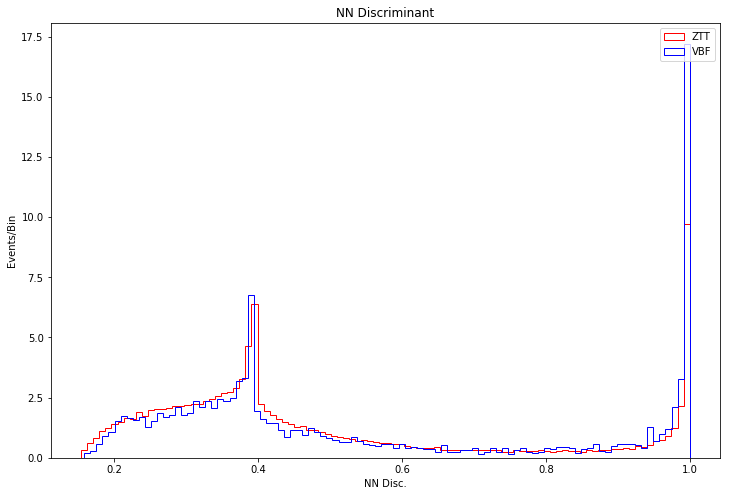

In [27]:
## define the function for making plots of the NN discriminat value
def discPlot(model, sig, bkg):
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler
    sig = sig.values[:, 0:6]
    bkg = bkg.values[:, 0:6]

    sig = StandardScaler().fit_transform(sig)
    bkg = StandardScaler().fit_transform(bkg)

    sig_pred = model.predict(sig)
    bkg_pred = model.predict(bkg)

    plt.figure(figsize=(12, 8))
    plt.title('NN Discriminant')
    plt.xlabel('NN Disc.')
    plt.ylabel('Events/Bin')
    plt.hist(bkg_pred, histtype='step', color='red', label='ZTT', bins=100, density=True)
    plt.hist(sig_pred, histtype='step', color='blue', label='VBF', bins=100, density=True)
    plt.legend()
discPlot(model, signal, background)

/Users/tmitchel/Documents/higgsToTauTau/studyNN/NNClassifiers/pyenv/lib/python2.7/site-packages/keras/engine/sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


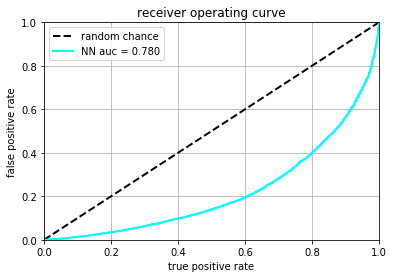

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
## define the function for plotting ROC curves
def ROC_curve(data_test, label_test, weights, model):
    from sklearn.metrics import roc_curve, auc

    label_predict = model.model.predict(data_test) ## use the model to do classifications
    fpr, tpr, _ = roc_curve(
        label_test, label_predict[:, 0], sample_weight=weights) ## calculate the ROC curve
    roc_auc = auc(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
             color='k', label='random chance')
    plt.plot(tpr, fpr, lw=2, color='cyan', label='NN auc = %.3f' % (roc_auc))
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    plt.xlabel('true positive rate')
    plt.ylabel('false positive rate')
    plt.title('receiver operating curve')
    plt.legend(loc="upper left")
    plt.grid()
## make some pretty plots
ROC_curve(data, label, weight, model)

In [19]:
## build the model
model = Sequential()
model.add(Dense(6, input_shape=(6,), name='input', activation='sigmoid'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
            EarlyStopping(monitor='val_loss', patience=50),
        ]

In [20]:
tt_bkg_df['isSignal'] = np.zeros(len(tt_bkg_df))
fat_panda_tt = pd.concat([signal, tt_bkg_df], sort=False)
all_data_tt = fat_panda_tt.values ## convert pandas dataframe -> numpy array

In [21]:
# split data into labels and also split into train/test
data_train_tt, data_test_tt, meta_train_tt, meta_test_tt = train_test_split(
    all_data_tt[:, :6], all_data_tt[:, 6:], test_size=0.05, random_state=7)

In [22]:
# normalize all input variables to improve performance
data_train_tt = StandardScaler().fit_transform(data_train_tt)

In [23]:
## separate the event weights and labels
data_tt = data_train_tt
weight_tt = meta_train_tt[:, 0]
label_tt = meta_train_tt[:, 1]

In [24]:
%%capture
model.fit(data_tt, label_tt, shuffle=True,
          epochs=10000, batch_size=1024, verbose=True,
          callbacks=callbacks, validation_split=0.25, sample_weight=weight_tt
          )

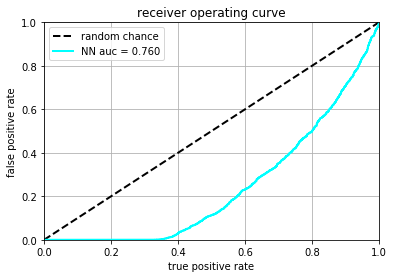

In [25]:
ROC_curve(data_tt, label_tt, weight_tt, model)

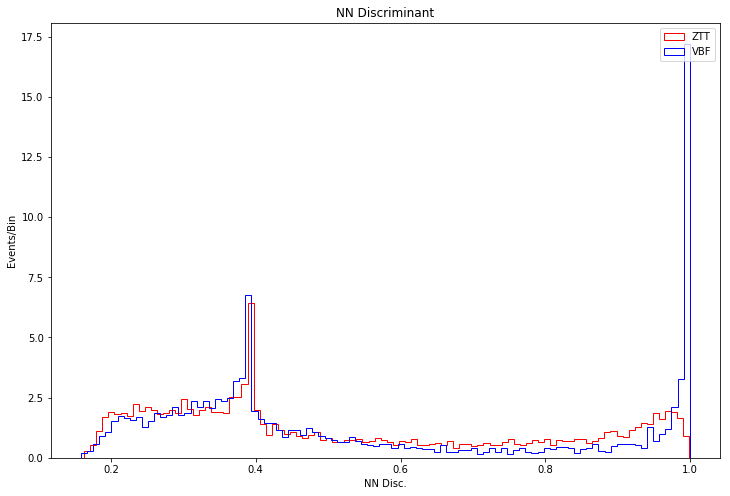

In [26]:
discPlot(model, signal, tt_bkg_df)